In [1]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

from scipy.stats import entropy
from scipy.special import rel_entr

from scipy.signal import butter, sosfilt
import random 

pd.set_option('display.max_columns', None)

from engine_hms_trainer import *
from engine_hms_model import JobConfig, ModelConfig


In [5]:
TARGET2ID = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

In [3]:
ModelConfig.EPOCHS = 6
ModelConfig.MODEL_BACKBONE = 'vit_mae_base'
ModelConfig.MODEL_NAME = "ViTMAE_base_mlp"
ModelConfig.AUGMENT = True
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENTATIONS = ['xy_masking']
ModelConfig.MAE_PRETRAINED_WEIGHTS = "./outputs/vit_mae_pretraining/best_mae_model.pth"
ModelConfig.MAE_HIDDEN_DROPOUT_PROB = 0.1
ModelConfig.MAE_ATTENTION_DROPOUT_PROB = 0.1


hms_predictor = HMSPredictor(JobConfig, ModelConfig)

****************************************************************************************************
Script Start: Wed Mar 13 19:13:16 2024
Model Configurations:
MODEL_NAME: ViTMAE_base_mlp
MODEL_BACKBONE: vit_mae_base
BATCH_SIZE: 16
EPOCHS: 6
GRADIENT_ACCUMULATION_STEPS: 2
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: True
AUGMENTATIONS: ['xy_masking']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
MAE_PRETRAINED_WEIGHTS: ./outputs/vit_mae_pretraining/best_mae_model.pth
MAE_HIDDEN_DROPOUT_PROB: 0.1
MAE_ATTENTION_DROPOUT_PROB: 0.1
****************************************************************************************************


In [4]:
train_easy, train_hard, all_specs, all_eegs = hms_predictor.load_train_data()

print(train_easy.shape)
print(train_hard.shape)

# check if contain NaN
print(train_easy.isnull().sum().sum())
print(train_hard.isnull().sum().sum())

display(train_easy.head())
print(" ")
display(train_hard.head())

(13996, 12)
(6187, 12)
0
0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


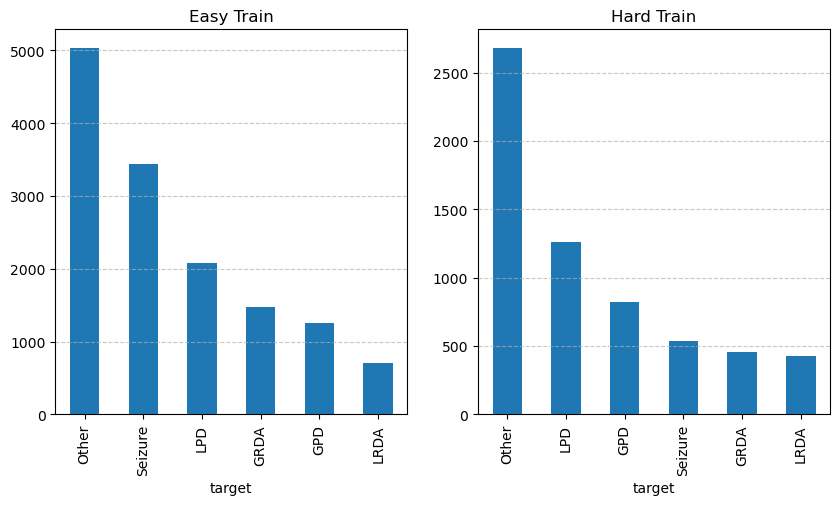

In [7]:
# check target distribution
train_easy['target_id'] = train_easy['target'].map(TARGET2ID)
train_hard['target_id'] = train_hard['target'].map(TARGET2ID)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

train_easy['target'].value_counts().plot(kind='bar', ax=axes[0], title='Easy Train')
train_hard['target'].value_counts().plot(kind='bar', ax=axes[1], title='Hard Train')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calc_confusion_matrix(oof_df):

    oof_df['target_id'] = oof_df['target'].map(TARGET2ID)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]

    return cm, oof_df


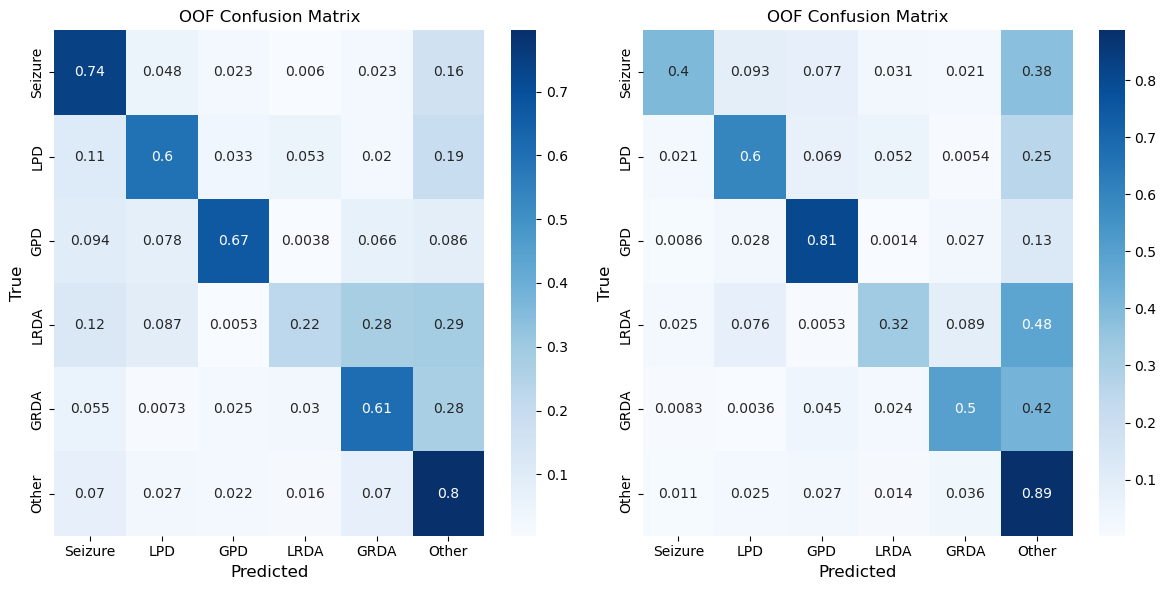

In [11]:
oof_dir = "./outputs/ENet_b2_xymasking_remove_less"

oof_df_1 = pd.read_csv(f"{oof_dir}/ENet_b2_xymasking_remove_less_oof_1.csv")
cm_1, oof_df_1 = calc_confusion_matrix(oof_df_1)

oof_df_2 = pd.read_csv(f"{oof_dir}/ENet_b2_xymasking_remove_less_oof_2.csv")
cm_2, oof_df_2 = calc_confusion_matrix(oof_df_2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_1, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys(), ax=axes[0])
sns.heatmap(cm_2, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys(), ax=axes[1])

for ax in axes:
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title('OOF Confusion Matrix', fontsize=12)

fig.tight_layout()
plt.show()